# 🌌 Quantum Three-Body Simulation

This notebook demonstrates simulations of a three-qubit quantum system, exploring analogies to the classical three-body problem. It features GPU acceleration for improved performance when available.

## Features
- Ising model simulations
- Heisenberg model simulations
- Gravitational analog simulations
- Quantum chaos metrics
- Interactive visualizations

In [1]:
# Apply dark mode styling for better visibility
from IPython.display import HTML, display

# Define dark theme - compatible with most Jupyter versions
dark_mode = """
<style>
    :root {
        --bg-color: #111;
        --text-color: #f0f0f0;
        --cell-bg: #1e1e1e;
        --input-bg: #2d2d2d;
        --border-color: #444;
        --accent-color: #59b6ff;
    }
    body { 
        background-color: var(--bg-color) !important; 
        color: var(--text-color) !important; 
    }
    div.cell { background-color: var(--cell-bg) !important; }
    div.input_area { background-color: var(--input-bg) !important; }
    div.output_area, div.output_subarea { 
        background-color: var(--cell-bg) !important; 
        color: var(--text-color) !important; 
    }
    .rendered_html, .text_cell_render { color: var(--text-color) !important; }
    .CodeMirror { background-color: var(--input-bg) !important; color: var(--text-color) !important; }
    .prompt { color: #999 !important; }
</style>
"""
display(HTML(dark_mode))

# Configure matplotlib for dark background
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams.update({
    'figure.facecolor': '#222',
    'axes.facecolor': '#222',
    'axes.edgecolor': '#999',
    'axes.labelcolor': '#f0f0f0',
    'xtick.color': '#f0f0f0',
    'ytick.color': '#f0f0f0',
    'text.color': '#f0f0f0',
})

print("✅ Applied dark mode styling")

✅ Applied dark mode styling


In [2]:
# Import required dependencies and setup environment
import os
import sys
import time
import numpy as np
import qutip as qt
import warnings

# Add project root to Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

# Suppress FutureWarning from QuTiP options
warnings.filterwarnings('ignore', category=FutureWarning)

# Check CuPy availability and patch if needed
try:
    import cupy as cp
    print(f"✅ CuPy version {cp.__version__} available")
    
    # Check CUDA version and GPU
    try:
        cuda_version = cp.cuda.runtime.runtimeGetVersion()
        device_props = cp.cuda.runtime.getDeviceProperties(0)
        print(f"✅ CUDA version: {cuda_version//1000}.{(cuda_version%1000)//10}")
        print(f"✅ GPU: {device_props['name'].decode()}")
        print(f"✅ Memory: {device_props['totalGlobalMem']/1e9:.1f} GB")
        
        # Apply monkey patch for set_default_dtype if needed
        if not hasattr(cp, 'set_default_dtype'):
            # Create a dummy function to prevent errors
            def set_default_dtype(dtype):
                pass
            cp.set_default_dtype = set_default_dtype
            print("✅ Applied compatibility patch for CuPy")
    except Exception as e:
        print(f"⚠️ CUDA information error: {e}")
except ImportError:
    print("⚠️ CuPy not installed. GPU acceleration not available.")
    print("   Install with: pip install cupy-cuda12x")
    # Create a dummy module to prevent import errors
    class DummyCupy:
        def __getattr__(self, name):
            return lambda *args, **kwargs: None
    sys.modules['cupy'] = DummyCupy()

# Import the simulation and visualization modules 
try:
    from src.simulation import SimulationPresets
    from src.visualization import (
        plot_three_qubit_bloch_spheres,
        plot_entanglement_metrics,
        plot_quantum_chaos_metrics,
        animate_bloch_spheres,
        create_phase_space_3d
    )
    print("✅ Successfully imported simulation modules")
except Exception as e:
    print(f"❌ Error importing modules: {e}")
    print("Please check that the repository structure is correct")

Added /home/ty/Repositories/ai_workspace/quantum_three_body to Python path
✅ CuPy version 13.4.1 available
✅ CUDA version: 12.8
✅ GPU: NVIDIA GeForce RTX 3060
✅ Memory: 12.5 GB
✅ Applied compatibility patch for CuPy
GPU acceleration enabled on device 0
Using NVIDIA GeForce RTX 3060
CUDA compute capability: (8, 6)
Total memory: 12.50 GB
✅ Successfully imported simulation modules


In [3]:
# Define helper functions for simulation execution and monitoring

def run_simulation_with_status(simulation_function, **params):
    """Run a simulation with progress reporting and error handling"""
    print(f"🚀 Running {simulation_function.__name__} with parameters:")
    for key, value in params.items():
        print(f"   - {key}: {value}")
    
    # Create proper QuTiP options object
    options = qt.Options(nsteps=2000, atol=1e-8, rtol=1e-6, store_states=True)
    
    # Time the execution
    start_time = time.time()
    
    try:
        # Run the simulation
        results = simulation_function(**params)
        execution_time = time.time() - start_time
        
        # Report performance metrics
        print(f"✅ Simulation completed in {execution_time:.2f} seconds")
        
        # Check if GPU was utilized
        if hasattr(results['dynamics'], 'performance_stats'):
            perf = results['dynamics'].performance_stats
            if perf.get('gpu_utilization', 0) > 0:
                print(f"   GPU acceleration: Active")
            else:
                print(f"   GPU acceleration: Inactive (using CPU)")
        
        return results
    
    except Exception as e:
        execution_time = time.time() - start_time
        print(f"❌ Simulation failed after {execution_time:.2f} seconds")
        print(f"   Error: {e}")
        return None

def plot_results_safely(plotting_function, data, title=None):
    """Plot results with error handling"""
    try:
        if title:
            fig = plotting_function(data, title=title)
        else:
            fig = plotting_function(data)
        plt.show()
        return fig
    except Exception as e:
        print(f"❌ Error plotting results: {e}")
        return None

## 1. Ising Model Simulation

The Ising model represents a system of interacting spins with nearest-neighbor coupling and a transverse magnetic field. It's a fundamental model in quantum mechanics that can exhibit interesting quantum phase transitions.

In [4]:
# Run Ising model simulation
ising_results = run_simulation_with_status(
    SimulationPresets.run_ising_model,
    J_coupling=1.0,
    h_field=0.5,
    initial_state_type='ghz',
    tmax=10.0,
    nsteps=500,  # Reduced for faster execution
    compute_metrics=True
)

🚀 Running run_ising_model with parameters:
   - J_coupling: 1.0
   - h_field: 0.5
   - initial_state_type: ghz
   - tmax: 10.0
   - nsteps: 500
   - compute_metrics: True
GPU acceleration enabled for quantum dynamics
Using CuPy version 13.4.1 with CUDA
GPU: NVIDIA GeForce RTX 3060
GPU simulation error (detailed): Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
GPU execution failed with error: Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
Falling back to CPU execution...
Simulation completed in 0.21 seconds
GPU acceleration: Inactive
Computing quantum chaos metrics with GPU acceleration...
Preparing perturbation 1/5
Preparing perturbation 2/5
Preparing perturbation 3/5
Preparing perturbation 4/5
Preparing perturbation 5/5
Evolving perturbed states in parallel on GPU...
Calculating fidelity decay...
Chaos metrics computation completed in 0.65 seconds
✅ Simulation completed in 1.49 seconds
   GPU acceleration: Inactive (u

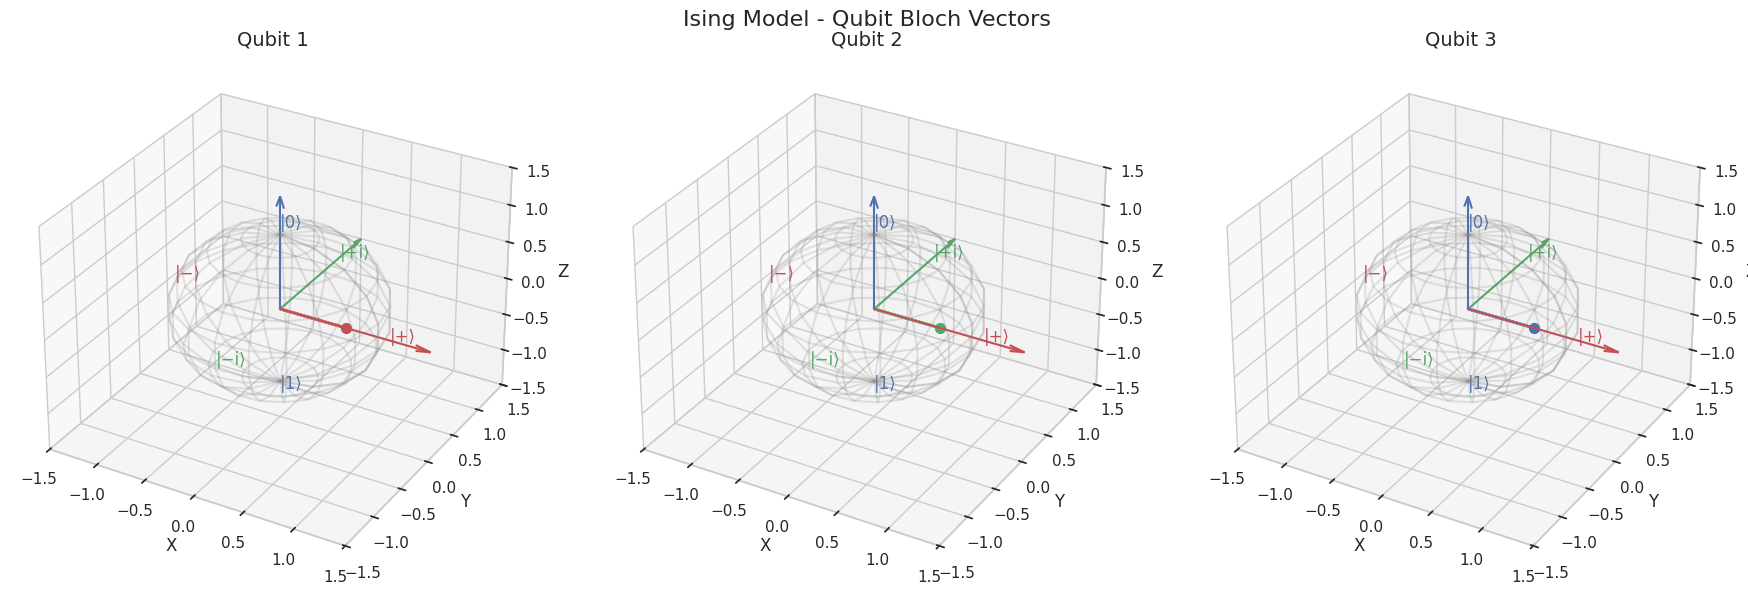

In [5]:
# Plot Bloch vectors if simulation was successful
if ising_results and 'metrics' in ising_results and 'bloch_vectors' in ising_results['metrics']:
    bloch_fig = plot_results_safely(
        plot_three_qubit_bloch_spheres,
        ising_results['metrics']['bloch_vectors'],
        title="Ising Model - Qubit Bloch Vectors"
    )
else:
    print("⚠️ No Bloch vector data available. Simulation may have failed.")

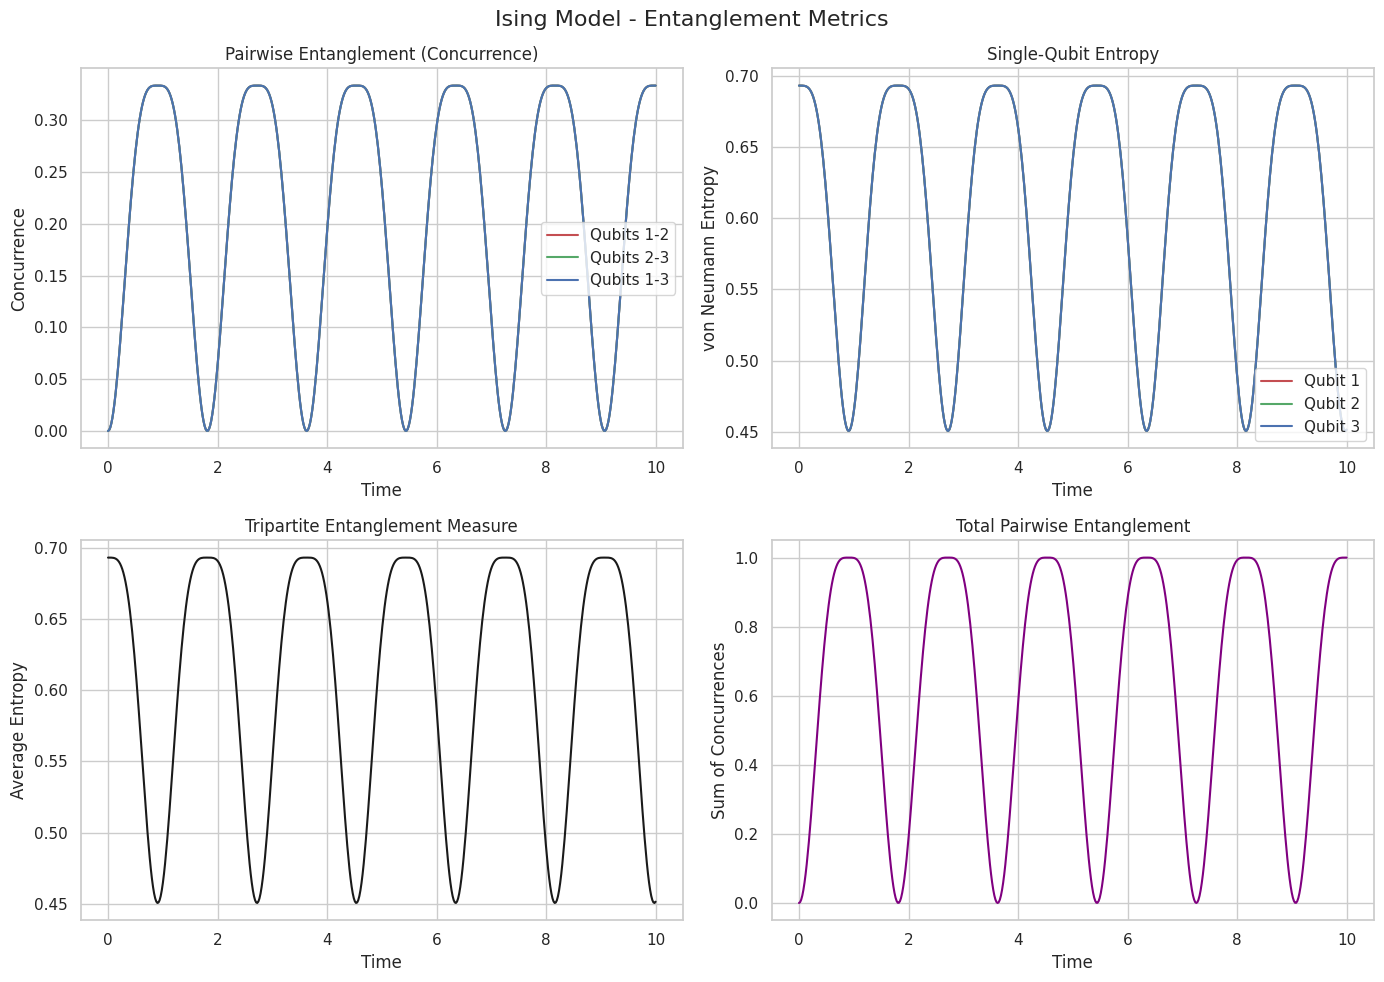

In [6]:
# Plot entanglement metrics if available
if ising_results and 'metrics' in ising_results and 'entanglement' in ising_results['metrics']:
    ent_fig = plot_results_safely(
        plot_entanglement_metrics,
        ising_results['metrics']['entanglement'],
        title="Ising Model - Entanglement Metrics"
    )
else:
    print("⚠️ No entanglement data available. Simulation may have failed.")

## 2. Heisenberg Model Simulation

The Heisenberg model represents interactions between neighboring spins in all three spatial dimensions. It's more isotropic than the Ising model and can lead to more complex quantum behavior.

In [7]:
# Run Heisenberg model simulation
heisenberg_results = run_simulation_with_status(
    SimulationPresets.run_heisenberg_model,
    J_coupling=1.0,
    anisotropy=0.5,  # Add some anisotropy in the z-direction
    initial_state_type='ghz',
    tmax=10.0,
    nsteps=500,  # Reduced for faster execution
    compute_metrics=True
)

🚀 Running run_heisenberg_model with parameters:
   - J_coupling: 1.0
   - anisotropy: 0.5
   - initial_state_type: ghz
   - tmax: 10.0
   - nsteps: 500
   - compute_metrics: True
GPU acceleration enabled for quantum dynamics
Using CuPy version 13.4.1 with CUDA
GPU: NVIDIA GeForce RTX 3060
Error converting to GPU arrays: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
GPU batch evolution failed: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
Falling back to CPU implementation
CPU batch evolution failed: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
GPU simulation error (detailed): Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
GPU execution failed with error: Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
Falling back to CPU execution...
Simulation completed in 0.02 seconds
GPU acceleration: Inactive
Computing quantum chaos metrics with GPU acceleration...
Preparing perturbation 1/5
Preparing perturbation 2/

/home/ty/Repositories/ai_workspace/quantum_three_body/src/dynamics.py:598: RuntimeWarning: divide by zero encountered in scalar divide
  return 1.0 / self.times[i]  # Rate of divergence


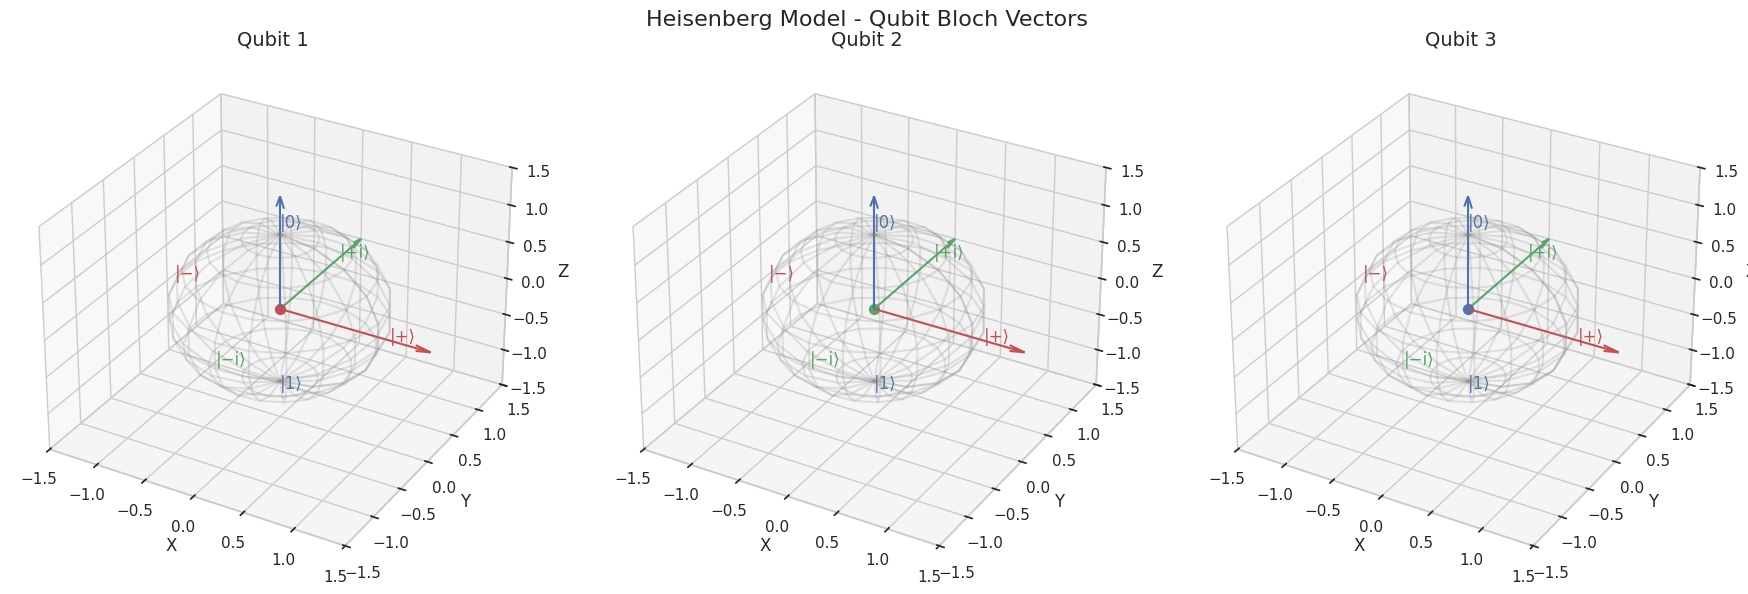

In [8]:
# Plot Bloch vectors for the Heisenberg model
if heisenberg_results and 'metrics' in heisenberg_results and 'bloch_vectors' in heisenberg_results['metrics']:
    bloch_fig = plot_results_safely(
        plot_three_qubit_bloch_spheres,
        heisenberg_results['metrics']['bloch_vectors'],
        title="Heisenberg Model - Qubit Bloch Vectors"
    )
else:
    print("⚠️ No Bloch vector data available. Simulation may have failed.")

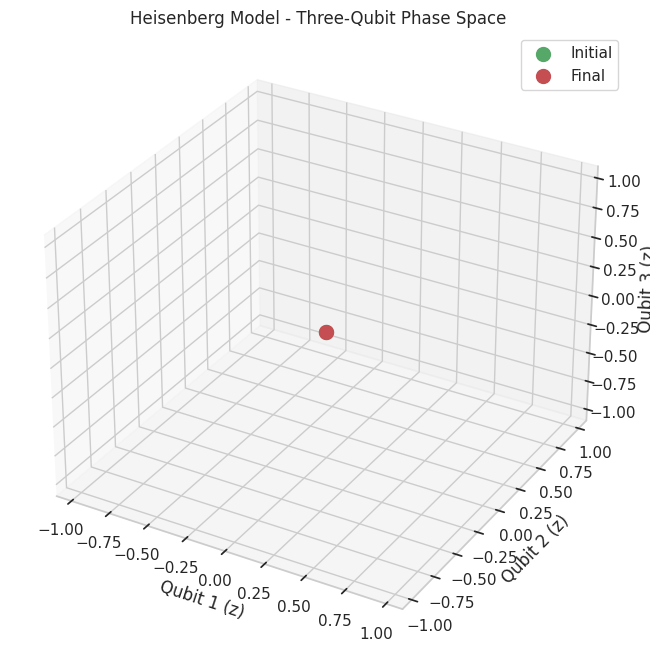

In [9]:
# Visualize the 3D phase space for the Heisenberg model
if heisenberg_results and 'metrics' in heisenberg_results and 'bloch_vectors' in heisenberg_results['metrics']:
    phase_fig = plot_results_safely(
        create_phase_space_3d,
        heisenberg_results['metrics']['bloch_vectors'],
        title="Heisenberg Model - Three-Qubit Phase Space"
    )
else:
    print("⚠️ No phase space data available. Simulation may have failed.")

## 3. Gravitational Analog Model

This model attempts to mimic gravitational-like interactions between qubits, creating an analog to the classical three-body problem in quantum mechanics.

In [10]:
# Run gravitational analog simulation with safer parameters
grav_results = run_simulation_with_status(
    SimulationPresets.run_gravitational_analog_model,
    G=1.0,
    decay_power=1.0,
    driving_strength=0.2,
    initial_state_type='product',  # Use product state with different "masses"
    tmax=10.0,   
    nsteps=500,  # Reduced for faster execution
    compute_metrics=True
)

🚀 Running run_gravitational_analog_model with parameters:
   - G: 1.0
   - decay_power: 1.0
   - driving_strength: 0.2
   - initial_state_type: product
   - tmax: 10.0
   - nsteps: 500
   - compute_metrics: True
GPU acceleration enabled for quantum dynamics
Using CuPy version 13.4.1 with CUDA
GPU: NVIDIA GeForce RTX 3060
Error converting to GPU arrays: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
GPU batch evolution failed: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
Falling back to CPU implementation
CPU batch evolution failed: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
GPU simulation error (detailed): Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
GPU execution failed with error: Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
Falling back to CPU execution...
Simulation completed in 0.02 seconds
GPU acceleration: Inactive
Computing quantum chaos metrics with GPU acceleration...
Preparing perturbat

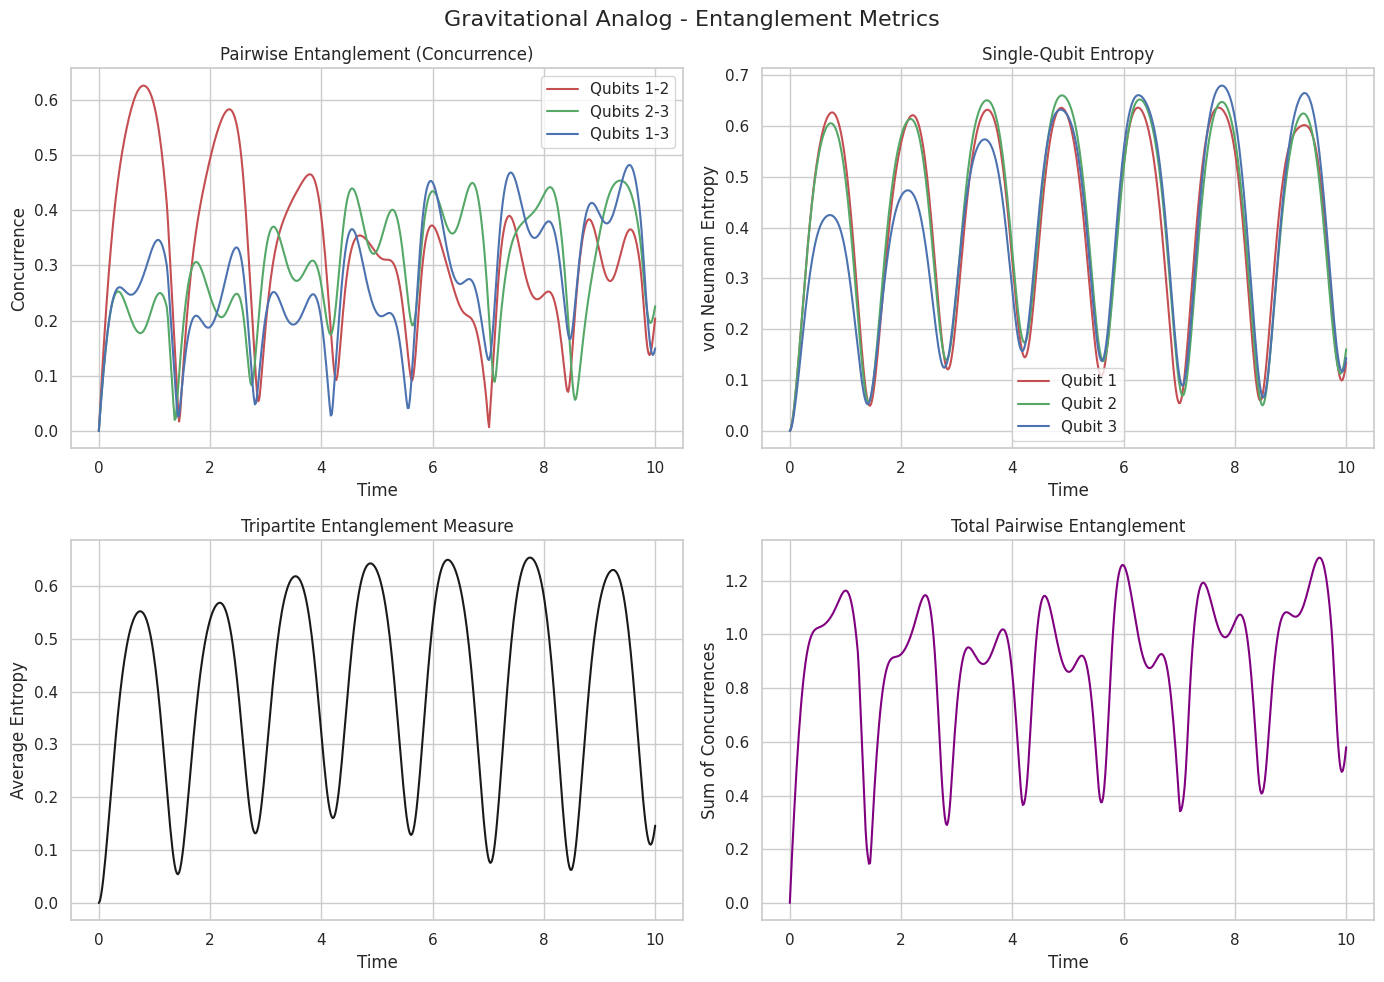

In [11]:
# Plot entanglement metrics for the gravitational model
if grav_results and 'metrics' in grav_results and 'entanglement' in grav_results['metrics']:
    ent_fig = plot_results_safely(
        plot_entanglement_metrics,
        grav_results['metrics']['entanglement'],
        title="Gravitational Analog - Entanglement Metrics"
    )
else:
    print("⚠️ No entanglement data available. Simulation may have failed.")

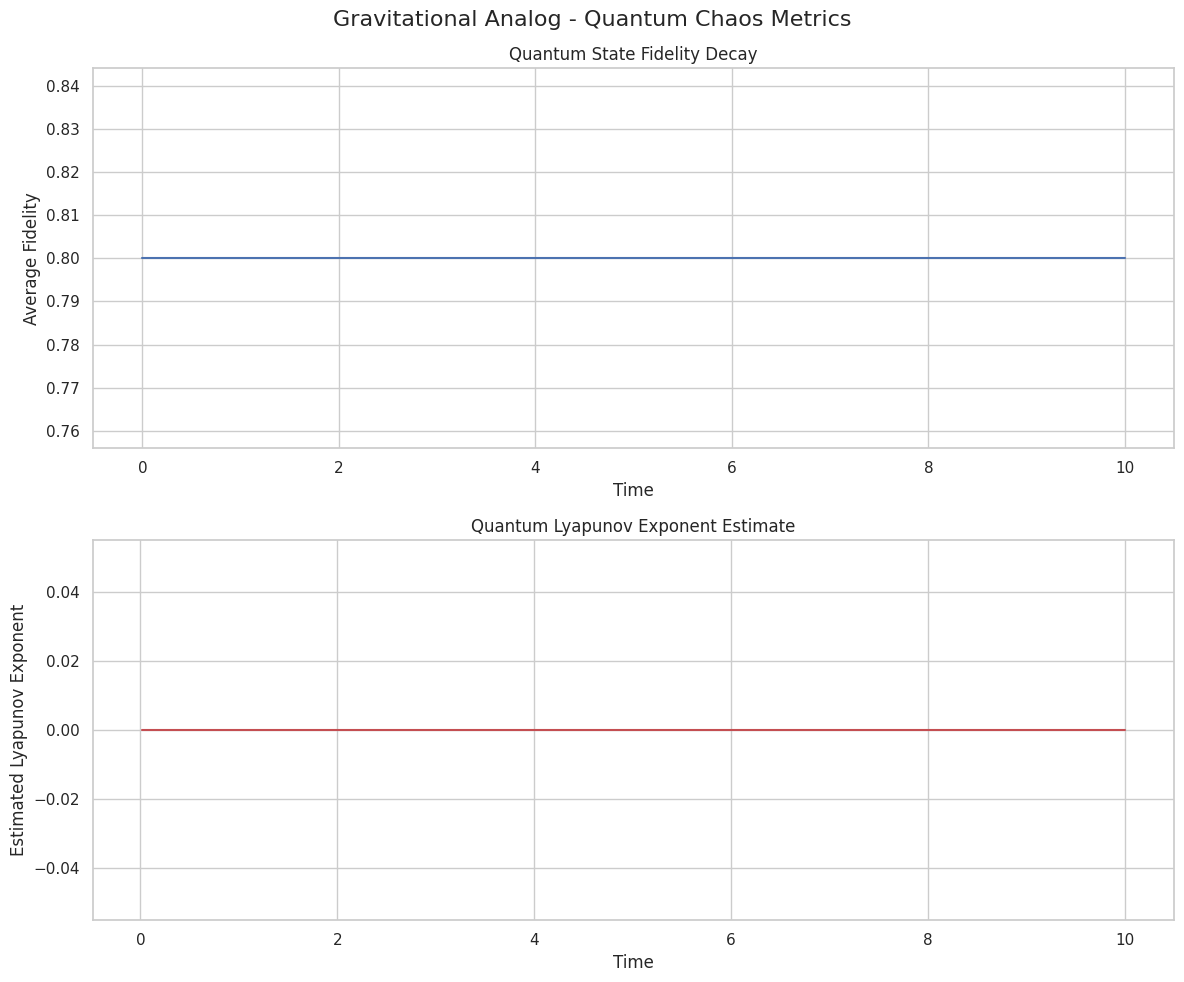

In [12]:
# Plot chaos metrics if available
if grav_results and 'metrics' in grav_results and 'chaos' in grav_results['metrics']:
    chaos_fig = plot_results_safely(
        plot_quantum_chaos_metrics,
        grav_results['metrics']['chaos'],
        title="Gravitational Analog - Quantum Chaos Metrics"
    )
else:
    print("⚠️ No chaos metrics available. Computation may have failed.")

Generating Bloch sphere animation (this may take a moment)...


Animation size has reached 21152445 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


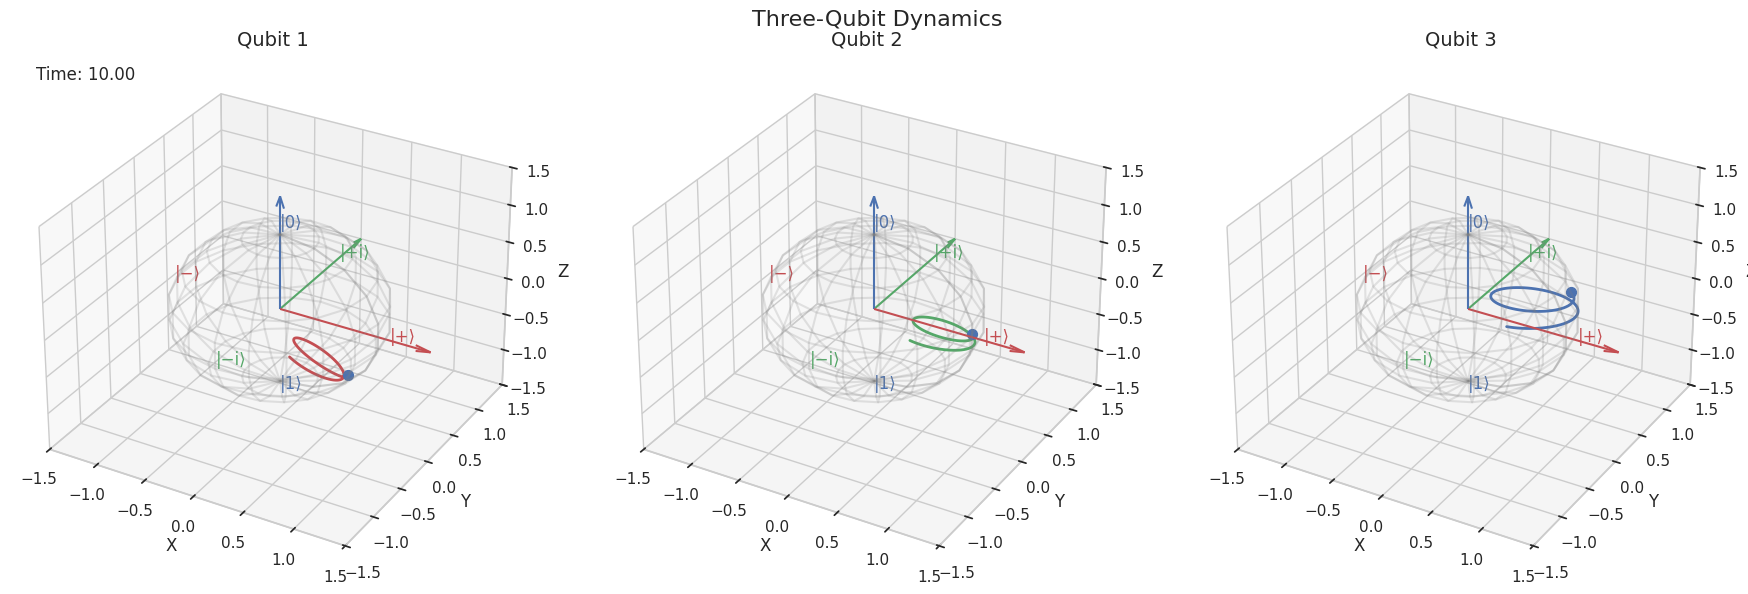

In [13]:
# Create an animation of the Bloch vectors (computationally intensive)
if grav_results and 'metrics' in grav_results and 'bloch_vectors' in grav_results['metrics']:
    try:
        # Prepare the animation with reduced complexity
        print("Generating Bloch sphere animation (this may take a moment)...")
        anim = animate_bloch_spheres(
            grav_results['metrics']['bloch_vectors'],
            interval=100,  # milliseconds between frames
            tail_fraction=0.2  # Show 20% of the trajectory as a "tail"
        )
        
        # Display the animation
        from IPython.display import HTML
        HTML(anim.to_jshtml())
    except Exception as e:
        print(f"❌ Error creating animation: {e}")
else:
    print("⚠️ No Bloch vector data available for animation.")

## 4. Time-Dependent Hamiltonian

This model demonstrates periodic driving of a quantum system, which can lead to resonance effects and complex dynamics.

In [14]:
# Run time-dependent simulation
time_dep_results = run_simulation_with_status(
    SimulationPresets.run_time_dependent_model,
    base_hamiltonian_type='ising',
    modulation_type='sinusoidal',
    amplitude=0.5,
    frequency=1.0,
    phase=0.0,
    initial_state_type='w',  # Use W state
    tmax=10.0,
    nsteps=500,  # Reduced for faster execution
    compute_metrics=True,
    # Additional parameters for the base Hamiltonian
    J_coupling=1.0,
    h_field=0.3
)

🚀 Running run_time_dependent_model with parameters:
   - base_hamiltonian_type: ising
   - modulation_type: sinusoidal
   - amplitude: 0.5
   - frequency: 1.0
   - phase: 0.0
   - initial_state_type: w
   - tmax: 10.0
   - nsteps: 500
   - compute_metrics: True
   - J_coupling: 1.0
   - h_field: 0.3
GPU acceleration enabled for quantum dynamics
Using CuPy version 13.4.1 with CUDA
GPU: NVIDIA GeForce RTX 3060
Simulation completed in 0.02 seconds
Computing quantum chaos metrics with GPU acceleration...
GPU chaos metrics computation failed: 'list' object has no attribute 'full'
GPU chaos metrics computation failed: 'list' object has no attribute 'full'
Falling back to CPU computation...
Running perturbation 1/5
✅ Simulation completed in 0.66 seconds
   GPU acceleration: Inactive (using CPU)


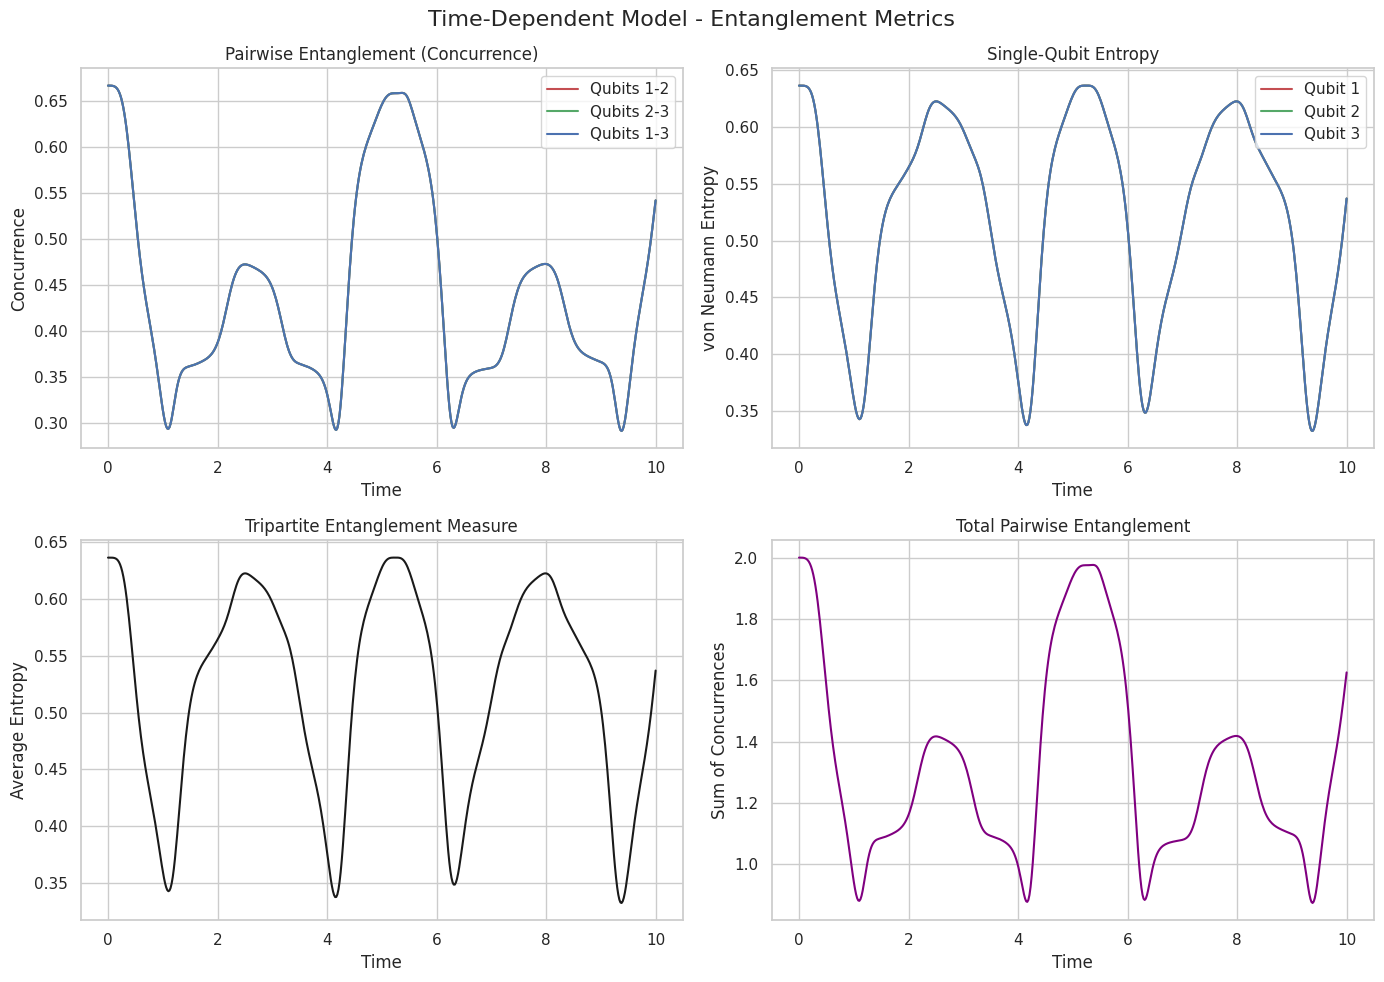

In [15]:
# Plot entanglement metrics for time-dependent model
if time_dep_results and 'metrics' in time_dep_results and 'entanglement' in time_dep_results['metrics']:
    ent_fig = plot_results_safely(
        plot_entanglement_metrics,
        time_dep_results['metrics']['entanglement'],
        title="Time-Dependent Model - Entanglement Metrics"
    )
else:
    print("⚠️ No entanglement data available. Simulation may have failed.")

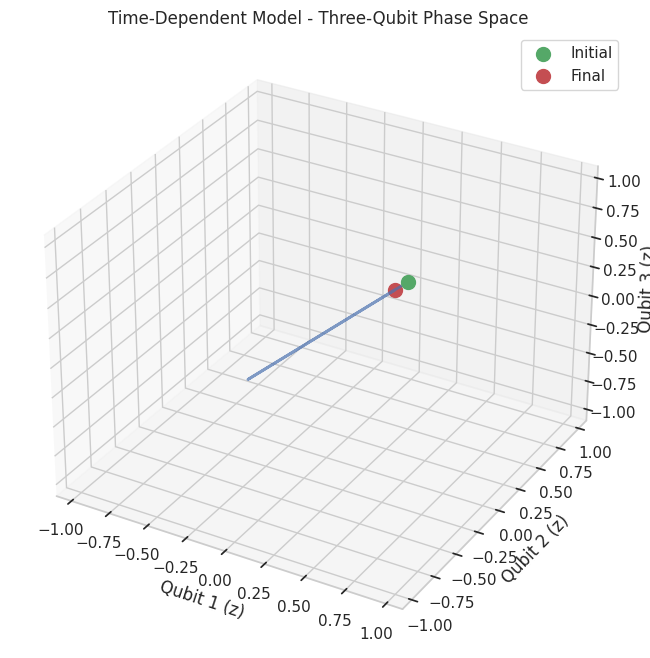

In [16]:
# Create 3D phase space visualization for time-dependent model
if time_dep_results and 'metrics' in time_dep_results and 'bloch_vectors' in time_dep_results['metrics']:
    phase_fig = plot_results_safely(
        create_phase_space_3d,
        time_dep_results['metrics']['bloch_vectors'],
        title="Time-Dependent Model - Three-Qubit Phase Space"
    )
else:
    print("⚠️ No phase space data available. Simulation may have failed.")

## Conclusion

This notebook demonstrates various quantum simulations of three-qubit systems, exploring analogies to the classical three-body problem. The simulations reveal interesting quantum behaviors including:

1. Entanglement dynamics that evolve over time
2. Bloch vector trajectories showing qubit state evolution
3. Quantum chaos metrics revealing sensitive dependence on initial conditions
4. Phase space behavior illustrating the system's dynamics

These quantum systems provide valuable insights into quantum-classical correspondence and the nature of quantum chaos.